Get data

In [59]:
file_path = "./data/X.csv"
X = pd.read_csv(file_path)

file_path = "./data/y.csv"
y = pd.read_csv(file_path)


In [275]:
df_org = X.join(y.set_index('id'))

df_mod = df_org

# clear all null lines
for column in df_mod.columns:
    nulls_mask = df_mod[column].notnull()  # or column_with_nulls.isna()
    df_mod = df_mod[nulls_mask]

# drop unnamed columns
df_mod.drop(columns='Unnamed: 0', inplace=True)
df_mod.drop(columns='Unnamed: 0.1',inplace=True)

# deal with categorial columns

df_mod_train, df_mod_test,_,_ =train_test_split(df_mod.drop(columns = 'Salary'), test_size = 0.3, random_state = 42) 

label_encoder = LabelEncoder()
for column in df_mod_train.select_dtypes(include=['object']).columns:
    df_mod_train[column + '_encoded'] = label_encoder.fit_transform(df_mod_train[column])





# get all relevant column names
categorical_columns = df_mod.select_dtypes(include=['object']).columns.tolist()

# drop_categorial = True
# if (drop_categorial):
#     df_mod = df_mod.drop(columns=categorical_columns)
# else:
#     # drop some of them
#     categorical_columns_remove = 'Job Title'
#     categorical_columns = [item for item in categorical_columns if item != categorical_columns_remove]


#     df_mod = pd.get_dummies(df_mod,columns = categorical_columns)

# df = df_mod
df_mod.info()

AttributeError: 'Series' object has no attribute 'set_index'

In [87]:
# sns.pairplot(df_mod,vars = ['Salary','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'])



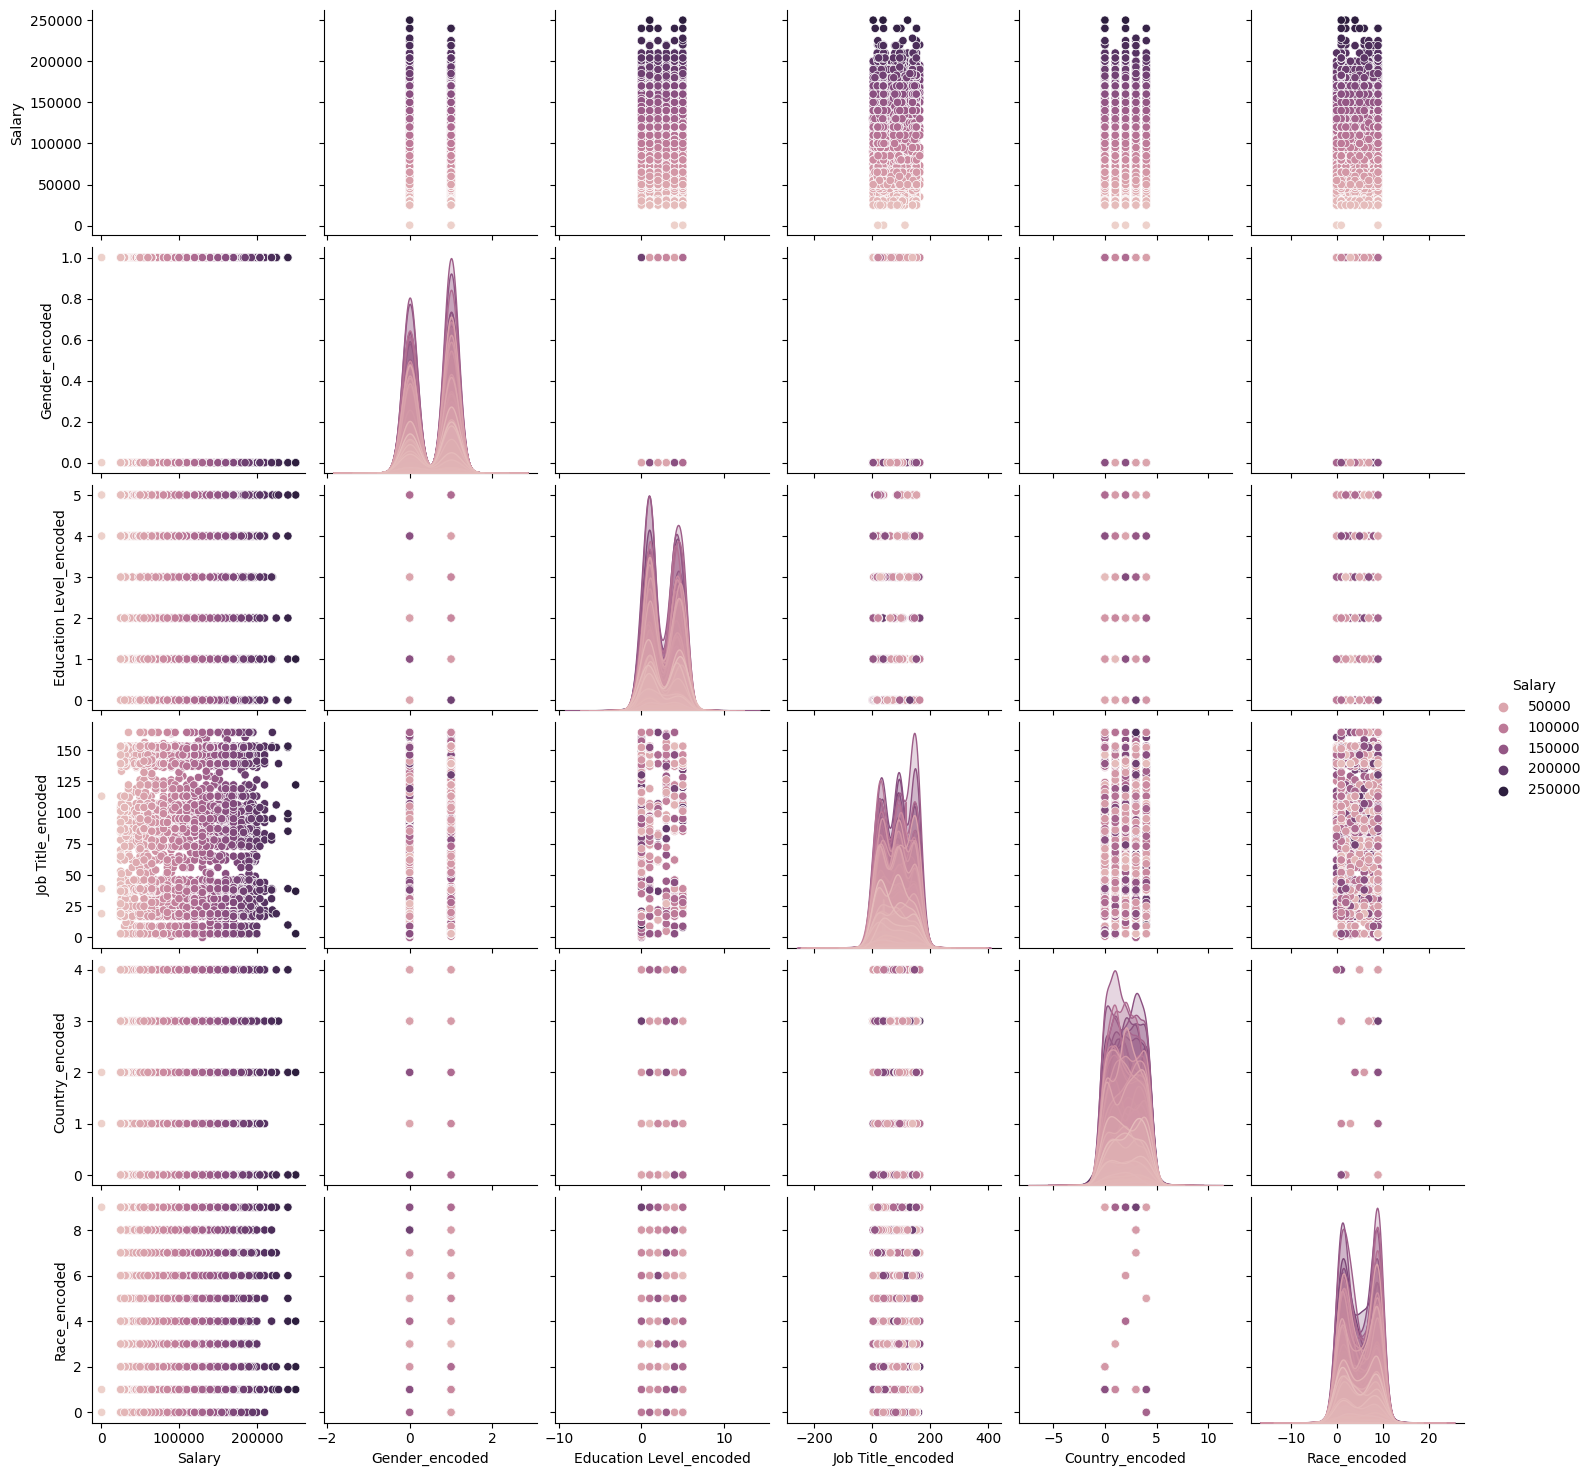

In [263]:
# removing data point with Gender = 'O'
# df_mod = df_mod[df_mod['Gender']!='O']

sns.pairplot(df_mod,vars = ['Salary','Gender_encoded', 'Education Level_encoded', 'Job Title_encoded', 'Country_encoded', 'Race_encoded'], hue = 'Salary')



<Axes: xlabel='Salary', ylabel='Job Title_encoded'>

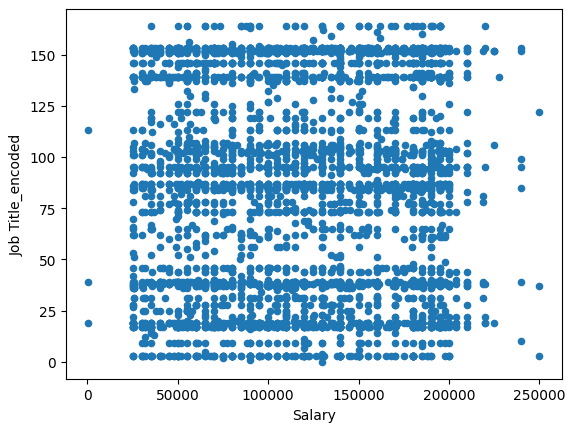

In [88]:
df_mod.plot.scatter('Salary', 'Job Title_encoded')

In [131]:
X_and_y = X.join(y.set_index('id'))
X_and_y.columns.values

array(['Unnamed: 0.1', 'Unnamed: 0', 'Age', 'Gender', 'Education Level',
       'Job Title', 'Years of Experience', 'Country', 'Race', 'height',
       'weight', 'id', 'professionalism', 'Salary'], dtype=object)

In [151]:
# X_and_y.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)
# X_and_y.set_index('id', inplace= True)
features = list(X_and_y.columns.values)
features

['Age',
 'Gender',
 'Education Level',
 'Job Title',
 'Years of Experience',
 'Country',
 'Race',
 'height',
 'weight',
 'professionalism',
 'Salary']

In [149]:
# X_and_y.columns
# X_and_y.drop(columns = ['Salary','Unnamed: 0.1', 'Unnamed: 0'], inplace = True)
# X_and_y = X_and_y.join(y.set_index('id'))
X_and_y.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Country', 'Race', 'height', 'weight', 'professionalism', 'Salary'],
      dtype='object')

In [194]:
df_mod = df_mod[['Age','Gender_encoded','Education Level_encoded','Job Title_encoded','Country_encoded', 'Race_encoded','Salary']]

In [271]:
# X_and_y.groupby(['Country','Age', 'Gender','Education Level'])['Salary'].aggregate('count').sort_values().head(500)

X = X_and_y.drop(columns = 'Salary')
y = X_and_y.Salary

In [272]:
# My solution
# Read the diet text file
# run lasso, ridge with 5 configuration each, which variables has the highest impact?
# which of the two methods shows it more clearly?

# X = X
# y = diet['change.kg']

from sklearn.metrics import mean_squared_error

# split
X_train, X_test, y_train, y_test = train_test_split(df_mod[['Gender_encoded','Race_encoded']], df_mod.Salary, test_size=0.33, random_state=42)

# define alphas to interate through
alphas = [0.001, 0.01, 0.1,1, 10,100, 1000,10000]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  lasso.fit(X_train, y_train)
  ridge.fit(X_train, y_train)

  # predict
  y_pred_lasso = lasso.predict(X_test)
  y_pred_ridge = ridge.predict(X_test)

  # score
  lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
  ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

  # print coeffiecients
  print(f"lasso rmse is {lasso_rmse:.1f} and ridge rmse is {ridge_rmse:.1f}")
  print(f'for alpha = {alpha}:')
  print(f"and features {X_train.columns.values}:")
  print(f"lasso coefficients are: {lasso.coef_}")
  print(f"ridge coefficients are: {ridge.coef_}\n")

lasso rmse is 51532.5 and ridge rmse is 51532.5
for alpha = 0.001:
and features ['Gender_encoded' 'Race_encoded']:
lasso coefficients are: [-1614.5888311    152.31354715]
ridge coefficients are: [-1614.59058192   152.31362783]

lasso rmse is 51532.5 and ridge rmse is 51532.5
for alpha = 0.01:
and features ['Gender_encoded' 'Race_encoded']:
lasso coefficients are: [-1614.55248944   152.31280562]
ridge coefficients are: [-1614.56999845   152.31361249]

lasso rmse is 51532.5 and ridge rmse is 51532.5
for alpha = 0.1:
and features ['Gender_encoded' 'Race_encoded']:
lasso coefficients are: [-1614.18907288   152.30539035]
ridge coefficients are: [-1614.36419259   152.31345906]

lasso rmse is 51532.4 and ridge rmse is 51532.5
for alpha = 1:
and features ['Gender_encoded' 'Race_encoded']:
lasso coefficients are: [-1610.55490726   152.23123763]
ridge coefficients are: [-1612.3090164    152.31192101]

lasso rmse is 51532.1 and ridge rmse is 51532.3
for alpha = 10:
and features ['Gender_encoded' 

In [273]:
# My Solution - KNN

# n_neighbors = list(range(2,20))

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50]

for weight in weights:
  for leaf in leafs:
    # instantiate class object
    # print(val)
    # print(type(val))
    knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = 'ball_tree', leaf_size = leaf)
    
    # fit
    knr.fit(X_train,y_train)
    
    # predict
    y_pred_knn_train = knr.predict(X_train)
    y_pred_knn_test = knr.predict(X_test)
    
    # score
    knr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_knn_train))
    knr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))

    # print coeffiecients
    print(f"When weight equals {weight}:")
    print(f"K-Nearest Neighbour Reg. train model's rmse is {knr_rmse_train:.2f}")
    print(f"K-Nearest Neighbour Reg. test model's rmse is {knr_rmse_test:.2f}")
    print(f"rmse_test - rmse_train = {knr_rmse_test - knr_rmse_train}\n")

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 56722.79
K-Nearest Neighbour Reg. test model's rmse is 57236.26
rmse_test - rmse_train = 513.4718837720575

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 56266.36
K-Nearest Neighbour Reg. test model's rmse is 56979.13
rmse_test - rmse_train = 712.7699810231425

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 56634.73
K-Nearest Neighbour Reg. test model's rmse is 57265.98
rmse_test - rmse_train = 631.2552282305842

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 56634.73
K-Nearest Neighbour Reg. test model's rmse is 57265.98
rmse_test - rmse_train = 631.2552282305842

When weight equals uniform:
K-Nearest Neighbour Reg. train model's rmse is 56084.52
K-Nearest Neighbour Reg. test model's rmse is 55972.83
rmse_test - rmse_train = -111.68384101956326

When weight equals distance:
K-Nearest Neighbour Reg. train model's rmse is 56722.7

In [210]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2854 entries, 2447 to 3833
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      2854 non-null   float64
 1   Gender_encoded           2854 non-null   int32  
 2   Education Level_encoded  2854 non-null   int32  
 3   Job Title_encoded        2854 non-null   int32  
 4   Country_encoded          2854 non-null   int32  
 5   Race_encoded             2854 non-null   int32  
dtypes: float64(1), int32(5)
memory usage: 100.3 KB


In [227]:
# df2 = df_org.drop(columns = ['Unnamed: 0.1','Unnamed: 0'])
# df2.set_index('id', inplace =True)
# df2.columns

Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Country', 'Race', 'height', 'weight', 'professionalism', 'Salary'],
      dtype='object')

In [231]:
# X_train, X_test, y_train, y_test = train_test_split(df2['Job Title'], df2.Salary, test_size=0.33, random_state=42)

In [274]:

# Decision Tree Regressor - My Solution

min_samples_split = list(range(2,20+1))

for val in min_samples_split:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_split = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)


  # score
  dtr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_dtr))
  dtr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_dtr))
  # print coeffiecients
  print(f"When minimal samples split equals {val}:")
  print(f"Decision Tree reg. training model's rmse is {dtr_train_rmse:.4f}")
  print(f"Decision Tree reg. test model's rmse is {dtr_test_rmse:.4f}")
  print(f"the difference between train's and test's rmse's is {dtr_test_rmse - dtr_train_rmse:.2f}\n")  
  # print(f"and features {X.columns.values}:")
  # print(f"Decision Tree reg. model's coefficients are: {dtr.coef_}\n")

When minimal samples split equals 2:
Decision Tree reg. training model's rmse is 52128.7272
Decision Tree reg. test model's rmse is 51705.9322
the difference between train's and test's rmse's is -422.79

When minimal samples split equals 3:
Decision Tree reg. training model's rmse is 52128.7272
Decision Tree reg. test model's rmse is 51705.9322
the difference between train's and test's rmse's is -422.79

When minimal samples split equals 4:
Decision Tree reg. training model's rmse is 52128.7272
Decision Tree reg. test model's rmse is 51705.9322
the difference between train's and test's rmse's is -422.79

When minimal samples split equals 5:
Decision Tree reg. training model's rmse is 52128.7272
Decision Tree reg. test model's rmse is 51705.9322
the difference between train's and test's rmse's is -422.79

When minimal samples split equals 6:
Decision Tree reg. training model's rmse is 52128.7272
Decision Tree reg. test model's rmse is 51705.9322
the difference between train's and test's

,Unnamed: 0.1,Unnamed: 0,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,id,professionalism,Salary
0,2477,2477,52.0,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.800316,95.021957,2477,1150.0,90000.0
1,76,76,52.0,F,bachelor,operations|manage,23.0,us,White,2.451414,87.456039,76,1100.0,65000.0
2,64,64,27.0,M,bachelor,junior|accountan,2.0,australi,Australian,1.917509,56.997108,64,26.0,NaN
3,924,924,32.0,M,bachelor,data|analys,11.0,u,Welsh,2.160562,61.403169,924,279.0,NaN
4,242,242,39.0,F,bachelor,senior|product|manage,11.0,chin,Korean,1.794105,72.049210,242,380.0,200000.0
